## Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading

In [3]:
def load_variants_and_summaries(folder: os.PathLike) -> pd.DataFrame:
    dfs = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith('.evo'):
                filepath = os.path.join(root, filename)
                variant = os.path.dirname(filepath)[len(folder)+1:]
                df = pd.read_csv(filepath, sep='\t')
                df = df.set_index('generation_id')
                dfs.append((variant, df))
    return dict(dfs)

In [4]:
summary_per_variant = load_variants_and_summaries(folder='../evolution')

In [5]:
[(k, len(v)) for (k, v) in summary_per_variant.items()]

[('atavism=0.25/pmr=0.1/pma=-0.05', 74),
 ('atavism=0.25/pmr=0.1/pma=0.05', 74),
 ('atavism=0.25/pmr=0.25/pma=-0.05', 74),
 ('atavism=0.25/pmr=0.25/pma=0.05', 74),
 ('atavism=0.1/pmr=0.1/pma=-0.05', 74),
 ('atavism=0.1/pmr=0.1/pma=0.05', 74),
 ('atavism=0.1/pmr=0.25/pma=-0.05', 74),
 ('atavism=0.1/pmr=0.25/pma=0.05', 74),
 ('atavism=0.0/pmr=0.1/pma=-0.05', 74),
 ('atavism=0.0/pmr=0.1/pma=0.05', 74),
 ('atavism=0.0/pmr=0.25/pma=-0.05', 74),
 ('atavism=0.0/pmr=0.25/pma=0.05', 74)]

# Atavistm at 0%

In [6]:
def pool_series(ticks, values, fn):
    out = []
    prev_i = 0
    for i in ticks:
        section = list(values[prev_i:i])
        value = fn(section)
        out.append(value)
        prev_i = i
    return out

def max_pool_series(ticks, values):
    return pool_series(ticks, values, np.max)

def mean_pool_series(ticks, values):
    return pool_series(ticks, values, np.mean)

## Genetic Material over Generations

In [7]:
def plot_genetic_material_over_generations(df: pd.DataFrame, figlen: int = 8):
    
    def annotated_area(ax, ticks, values: pd.Series, color: str, label: str):
        values = mean_pool_series(ticks, values)
        ax.set_xticks(ticks)
        ax.fill_between(ticks, values, color=color, edgecolor='#fff', label=label)
        ax.plot(ticks, values, color="#ffffff", marker='o')

    def annotated_candles(ax, ticks, highs: pd.Series, lows: pd.Series, color: str, label: str):
        highs = mean_pool_series(ticks, highs)
        lows = mean_pool_series(ticks, lows)
        heights = [highs[i] - lows[i] for i in range(len(highs))]
        ax.set_xticks(ticks)
        ax.bar(ticks, height=heights, bottom=lows, width=2.5, color=color + 'cc', edgecolor=color, label=label)
        for i, h, l in zip(ticks, highs, lows):
            ax.text(i, h + 0.15, str(round(h, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))
            ax.text(i, l - 0.15, str(round(l, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))

    tickslen = len(df.index)
    ticksstep = max(1, int(tickslen / 15))
    ticks = np.arange(1, tickslen + 1, ticksstep)
    fig, ax = plt.subplots(figsize=(figlen, figlen/2))
    annotated_area(ax, ticks, df.entropy_dna_pool, color='#003f5c44', label='entropy (dna)')
    annotated_area(ax, ticks, df.entropy_fitness_scores, color='#58508d44', label='entropy (dna)')
    annotated_candles(ax, ticks, df.genes_max, df.genes_min, color='#bc5090', label='genes')
    ax.set_facecolor("#eee")
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4)
    ax.grid(True)
    ax.set_xlabel('generation')
    ax.set_ylabel('gene counts & entropy score')
    fig.subplots_adjust(bottom=0.25)
    fig.tight_layout()

#plot_genetic_material_over_generations(df=summary_per_variant.get('tests'))

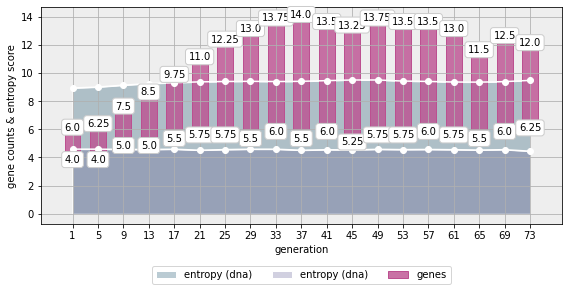

In [8]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=-0.05'))

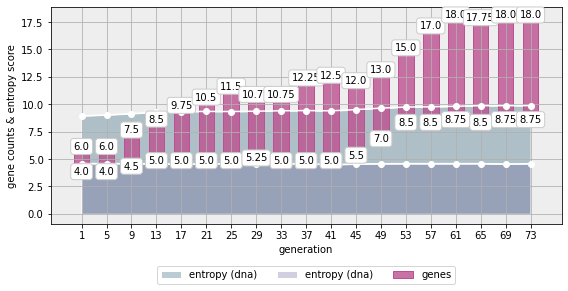

In [9]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=0.05'))

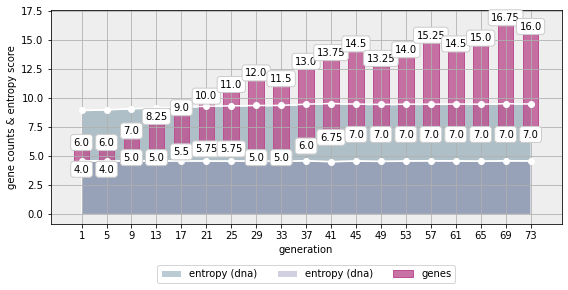

In [10]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=-0.05'))

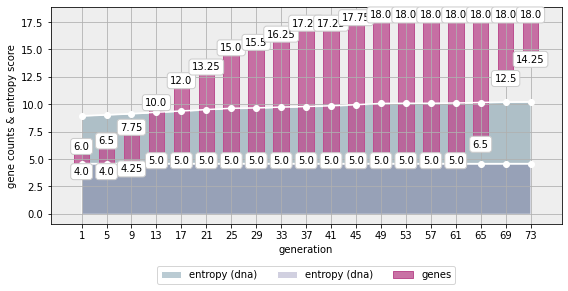

In [11]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=0.05'))

## Fitness over Generations

In [12]:
def calculate_leap_series(highs: pd.Series) -> pd.Series:
    leaps = []
    highs = list(highs)
    highest = 0.
    for high in highs:
        leap = highest and high > highest
        leaps.append(1. if leap else 0.)
        highest = max(high, highest)
    return pd.Series(leaps)

In [13]:
def plot_fitness_over_generations(df: pd.DataFrame, figlen: int = 8, fitent_yadjust: int = 0, meanfit_yadjust: int = 0):
    from numpy import trapz
    def annotated_line(ax, ticks, values: pd.Series, color: str, label: str, ydist: float = None, pool_type: str = 'mean'):
        values = mean_pool_series(ticks, values) if pool_type else max_pool_series(ticks, values)
        ax.set_xticks(ticks)
        ax.plot(ticks, values, marker='o', color=color, label=label)
        ydist = max(values) * ydist
        for i, v in zip(ticks, values):
            ax.text(i, v + ydist, str(round(v, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))
    def annotated_bar(ax, ticks, values: pd.Series, color: str, label: str, ydist: int):
        values = mean_pool_series(ticks, values)
        ax.set_xticks(ticks)
        ax.bar(ticks, height=values, color=color, edgecolor='#fff', width=5., label=label)
        for i, v in zip(ticks, values):
            ax.text(i, v + ydist, str(round(v, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="#ffac00", ec="#ccc", lw=1))
    tickslen = len(df.index)
    ticksstep = max(1, int(tickslen / 15))
    ticks = np.arange(1, tickslen + 1, ticksstep)
    df['leaps'] = calculate_leap_series(df.fitness_highest)
    
    normalised_leaps = mean_pool_series(ticks, df.leaps)
    print(f"Total Leaps: {len(df[df.leaps > 0])}")
    print(f"AUC of Lel(k): {trapz(normalised_leaps)}")
    print(f"Highest Fitness Scores: {float(df.fitness_highest.max())}")
    print(f"Mean Entropy of DNA Pool: {float(df.entropy_dna_pool.mean())}")
    print(f"Mean Entropy of Fitness Scores: {float(df.entropy_fitness_scores.mean())}")

    fig, ax = plt.subplots(figsize=(figlen, figlen))
    ax.set_facecolor("#eee")
    ax.grid(True)
    ax.set_xlabel('generation')
    ax.set_ylabel('Lel(k)')
    annotated_bar(ax, ticks, df.leaps, color='#bc509044', label='Lel(k)', ydist=0.025 + fitent_yadjust)
    ax.legend(loc='lower right', bbox_to_anchor=(0.5, -0.125), ncol=4)
    
    ax2 = ax.twinx()
    ax2.set_ylabel('fitness score & entropy score')
    annotated_line(ax2, ticks, df.fitness_highest, color='#003f5c', label='fitness (highest)', ydist=0.025, pool_type='max')
    annotated_line(ax2, ticks, df.fitness_mean, color='#58508d', label='fitness (mean)', ydist=0.45 + meanfit_yadjust)
    ax2.legend(loc='lower left', bbox_to_anchor=(0.5, -0.125), ncol=4)
    
    fig.subplots_adjust(bottom=0.25)
    fig.tight_layout()

#plot_fitness_over_generations(df=summary_per_variant.get('tests'))

Total Leaps: 7
AUC of Lel(k): 1.75
Highest Fitness Scores: 88.95427472020495
Mean Entropy of DNA Pool: 9.359795979392974
Mean Entropy of Fitness Scores: 4.55591272661821


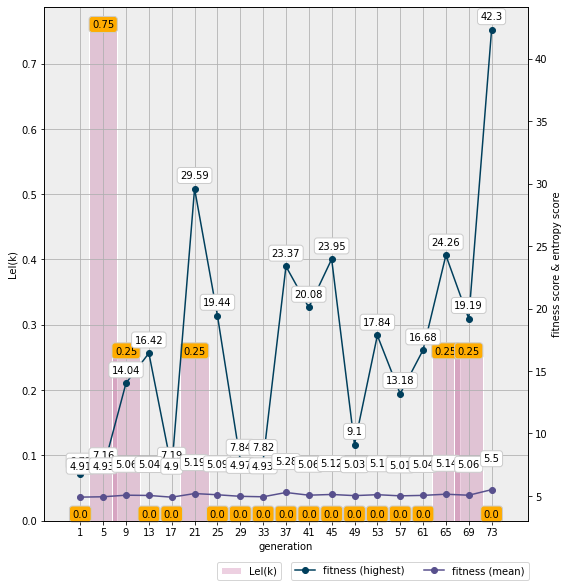

In [14]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=-0.05'), fitent_yadjust=-0.015)

Total Leaps: 4
AUC of Lel(k): 1.25
Highest Fitness Scores: 62.110671869990085
Mean Entropy of DNA Pool: 9.509631480985338
Mean Entropy of Fitness Scores: 4.568367117481582


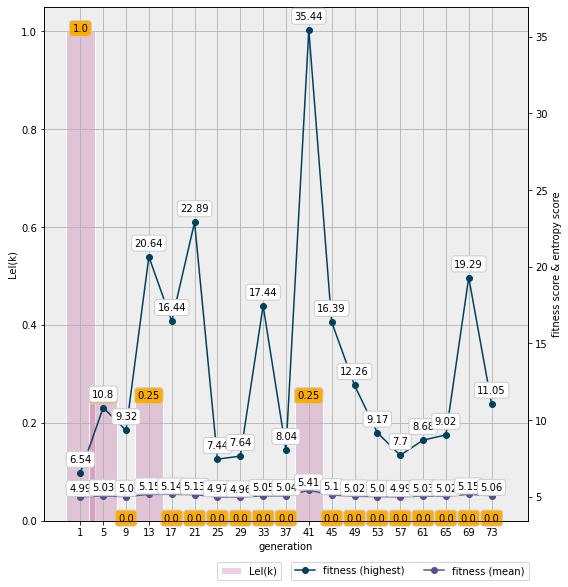

In [15]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=0.05'), fitent_yadjust=-0.02, meanfit_yadjust=-0.35)

Total Leaps: 4
AUC of Lel(k): 1.0
Highest Fitness Scores: 78.2157540714666
Mean Entropy of DNA Pool: 9.351079675364094
Mean Entropy of Fitness Scores: 4.570370312714402


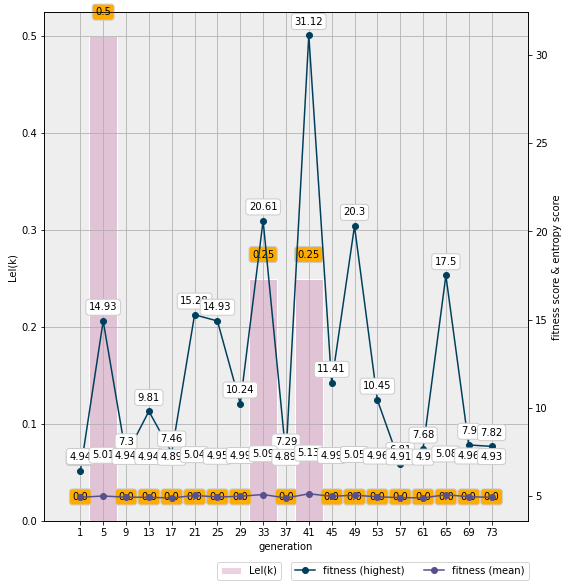

In [16]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=-0.05'))

Total Leaps: 2
AUC of Lel(k): 0.75
Highest Fitness Scores: 10.686745329211586
Mean Entropy of DNA Pool: 9.773909891043084
Mean Entropy of Fitness Scores: 4.586188461903805


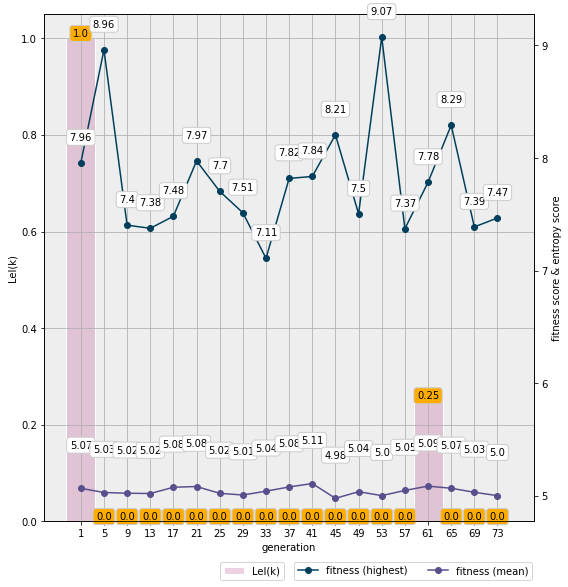

In [17]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=0.05'), fitent_yadjust=-0.015, meanfit_yadjust=-0.375)

In [22]:
variant_folder = 'atavism=0.0/'
results_table = []
for key, df in summary_per_variant.items():
    if key.startswith(variant_folder):
        results_table.append({
            'name': key,
            'mean(fintess_mean)': float(df.fitness_mean.mean()),
            'max(fitness_hightest)': float(df.fitness_highest.max()),
            'mean(leaps)': int(df[df.leaps >= 1.].leaps.count())
        })
pd.DataFrame(results_table).set_index('name').sort_index()

,mean(fintess_mean),max(fitness_hightest),mean(leaps)
name,,,
atavism=0.0/pmr=0.1/pma=-0.05,5.076209,88.954275,7
atavism=0.0/pmr=0.1/pma=0.05,5.071062,62.110672,4
atavism=0.0/pmr=0.25/pma=-0.05,4.979085,78.215754,4
atavism=0.0/pmr=0.25/pma=0.05,5.040392,10.686745,2


# Atavistm at 10%

Total Leaps: 6
AUC of Lel(k): 1.75
Highest Fitness Scores: 119.64855342965782
Mean Entropy of DNA Pool: 9.289619525296105
Mean Entropy of Fitness Scores: 4.538032544213199


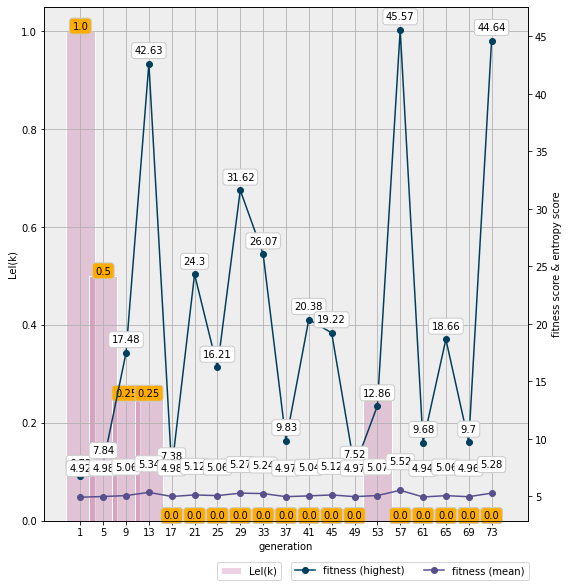

In [24]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.1/pma=-0.05'), fitent_yadjust=-0.015)

Total Leaps: 6
AUC of Lel(k): 1.75
Highest Fitness Scores: 101.33715178410132
Mean Entropy of DNA Pool: 9.553149382381452
Mean Entropy of Fitness Scores: 4.563832914568417


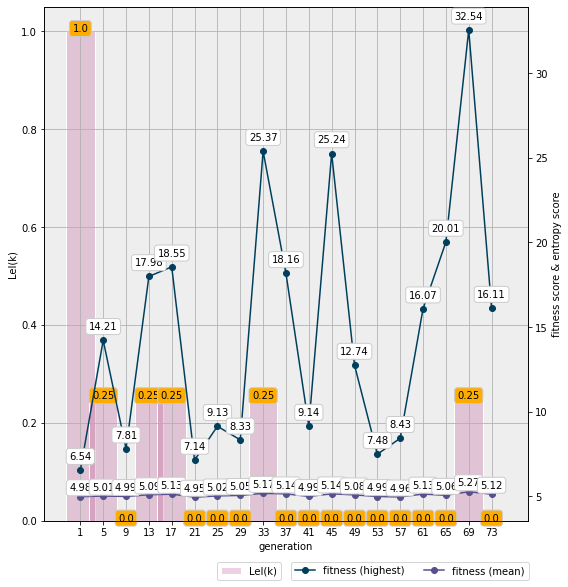

In [25]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.1/pma=0.05'), fitent_yadjust=-0.02, meanfit_yadjust=-0.35)

Total Leaps: 4
AUC of Lel(k): 1.25
Highest Fitness Scores: 75.75788405728731
Mean Entropy of DNA Pool: 9.511632603518718
Mean Entropy of Fitness Scores: 4.571445089895141


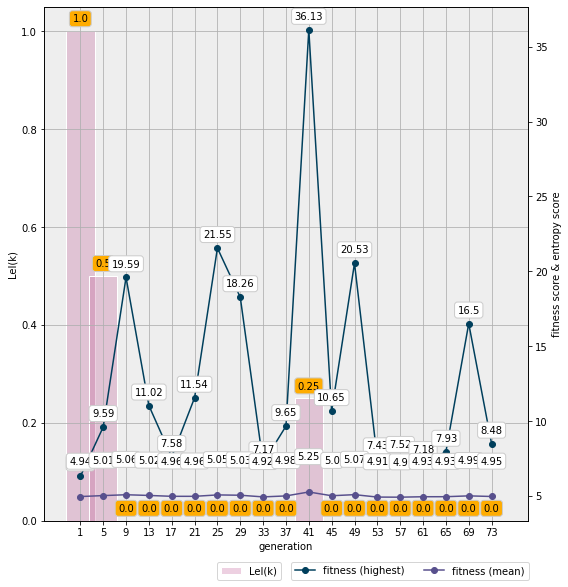

In [26]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.25/pma=-0.05'))

Total Leaps: 4
AUC of Lel(k): 1.0
Highest Fitness Scores: 11.50257587054135
Mean Entropy of DNA Pool: 9.848342220905186
Mean Entropy of Fitness Scores: 4.585386950761477


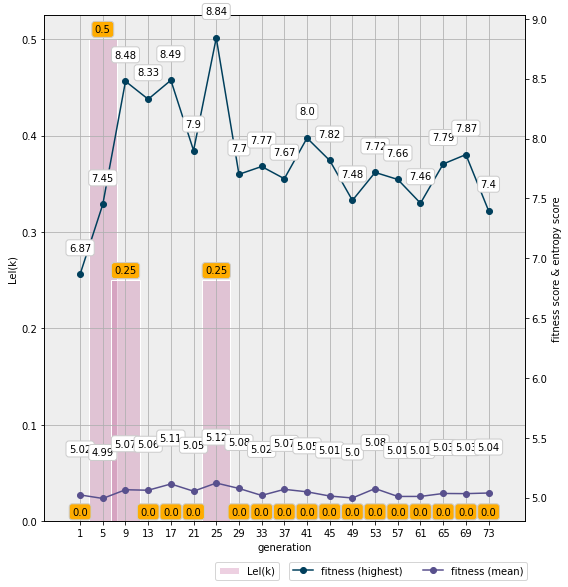

In [27]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.25/pma=0.05'), fitent_yadjust=-0.015, meanfit_yadjust=-0.375)

Total Leaps: 4
AUC of Lel(k): 1.25
Highest Fitness Scores: 104.33658385224942
Mean Entropy of DNA Pool: 9.289590433280878
Mean Entropy of Fitness Scores: 4.5545807526671895


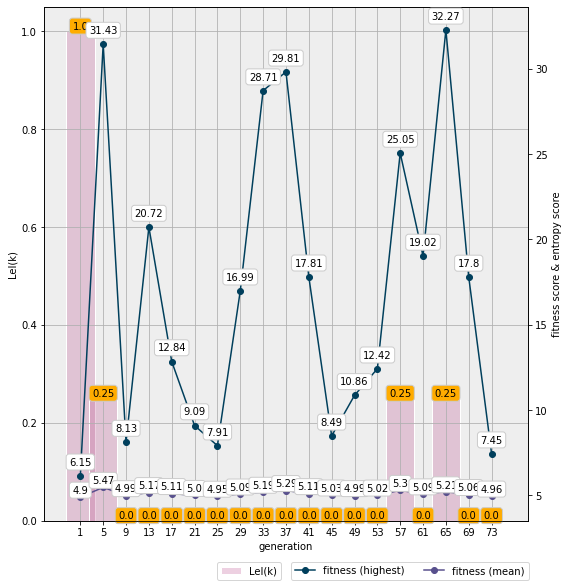

In [28]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.25/pmr=0.1/pma=-0.05'), fitent_yadjust=-0.015, meanfit_yadjust=-0.375)

Total Leaps: 4
AUC of Lel(k): 1.25
Highest Fitness Scores: 70.69082677631256
Mean Entropy of DNA Pool: 9.36358146161001
Mean Entropy of Fitness Scores: 4.569468099303764


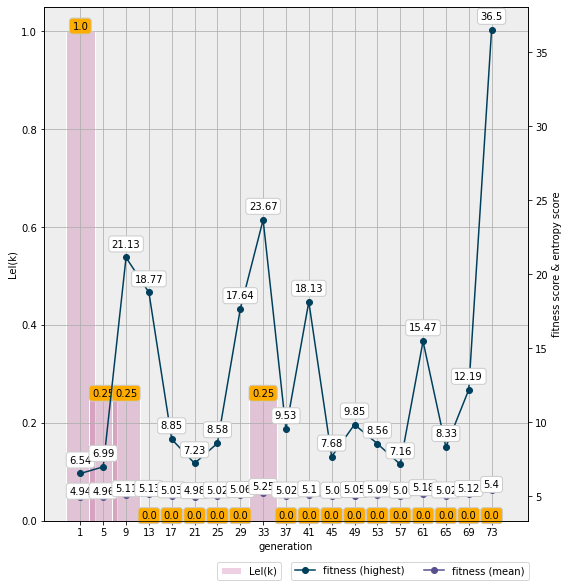

In [29]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.25/pmr=0.1/pma=0.05'), fitent_yadjust=-0.015, meanfit_yadjust=-0.375)

Total Leaps: 8
AUC of Lel(k): 2.25
Highest Fitness Scores: 826.6970010538793
Mean Entropy of DNA Pool: 9.335575597344349
Mean Entropy of Fitness Scores: 4.513754000117121


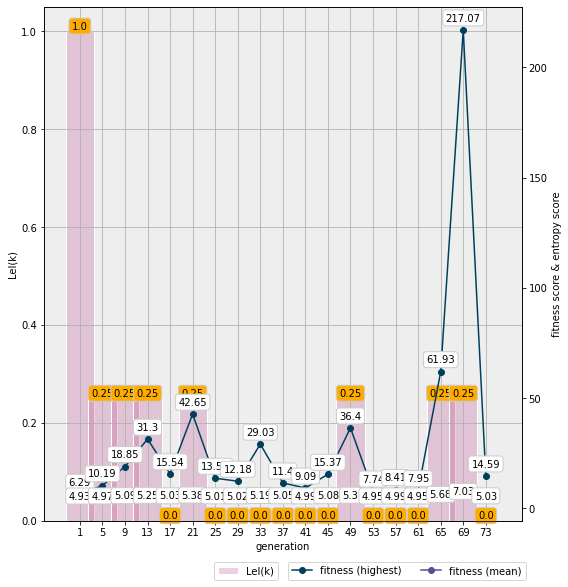

In [30]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.25/pmr=0.25/pma=-0.05'), fitent_yadjust=-0.015, meanfit_yadjust=-0.375)

Total Leaps: 6
AUC of Lel(k): 1.75
Highest Fitness Scores: 11.328832006447962
Mean Entropy of DNA Pool: 9.813759065622836
Mean Entropy of Fitness Scores: 4.586788473991162


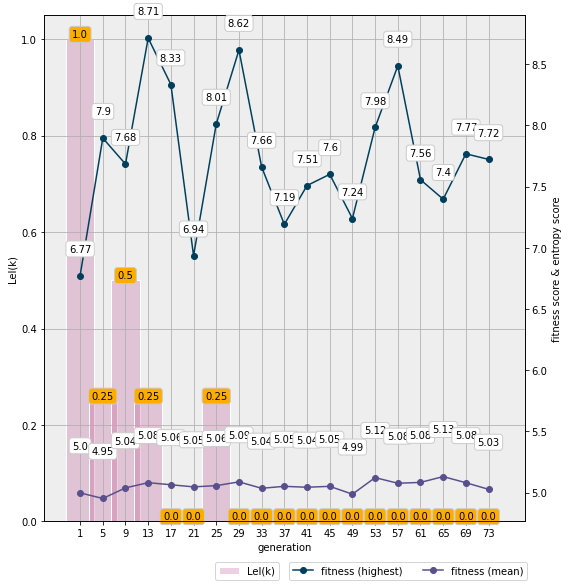

In [31]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.25/pmr=0.25/pma=0.05'), fitent_yadjust=-0.015, meanfit_yadjust=-0.375)

In [33]:
variant_folders = ['atavism=0.1/', 'atavism=0.25/']
results_table = []
for key, df in summary_per_variant.items():
    if any(key.startswith(variant_folder) for variant_folder in variant_folders):
        results_table.append({
            'name': key,
            'mean(fintess_mean)': float(df.fitness_mean.mean()),
            'max(fitness_hightest)': float(df.fitness_highest.max()),
            'mean(leaps)': int(df[df.leaps >= 1.].leaps.count())
        })
pd.DataFrame(results_table).set_index('name').sort_index()

,mean(fintess_mean),max(fitness_hightest),mean(leaps)
name,,,
atavism=0.1/pmr=0.1/pma=-0.05,5.111691,119.648553,6
atavism=0.1/pmr=0.1/pma=0.05,5.070379,101.337152,6
atavism=0.1/pmr=0.25/pma=-0.05,4.992897,75.757884,4
atavism=0.1/pmr=0.25/pma=0.05,5.047428,11.502576,4
atavism=0.25/pmr=0.1/pma=-0.05,5.108345,104.336584,4
atavism=0.25/pmr=0.1/pma=0.05,5.081845,70.690827,4
atavism=0.25/pmr=0.25/pma=-0.05,5.214016,826.697001,8
atavism=0.25/pmr=0.25/pma=0.05,5.057269,11.328832,6
